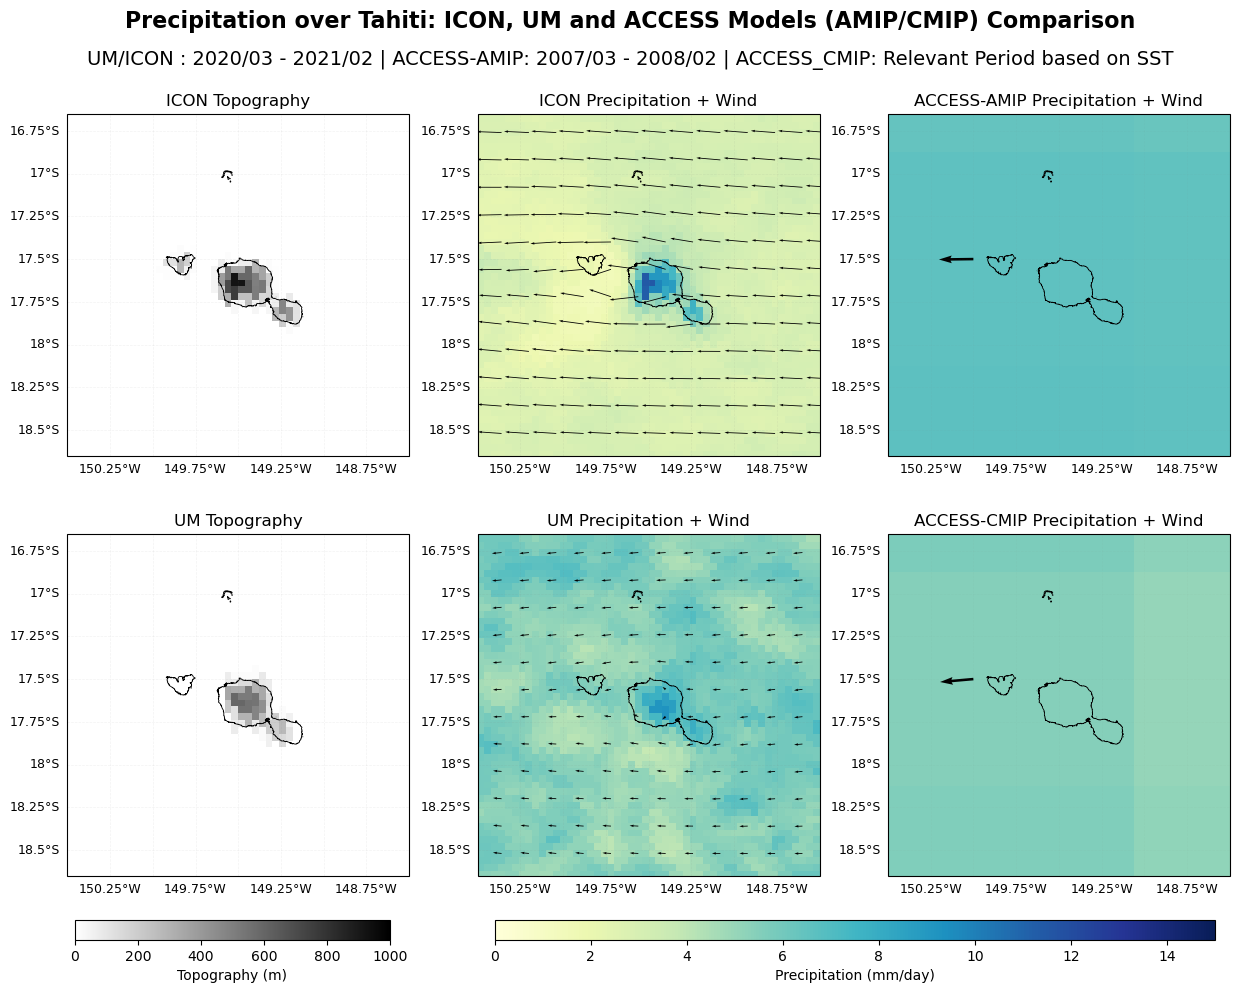

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import numpy as np

# File paths
files_path = '/scratch/nf33/hk25-ConvZones'

amip_file = f'{files_path}/access_amip_ensemble_tot_avg_200703_200802.nc'
cmip_file = f'{files_path}/access_cmip_ensemble_tot_avg.nc'
ge_file   = f'{files_path}/ICON_tot_avg_202003_202102_Z10.nc'
uk_file   = f'{files_path}/UM_tot_avg_202003_202102_Z10.nc'

ge_topo   = f'{files_path}/ICON_topo_Z10.nc'
uk_topo   = f'{files_path}/UM_topo_Z10.nc'

# Custom shapefile path
shp_path = '/home/263/pm8621/hk25-AusNode-TConvZones/custom_coastlines/PF_V02.shp'

# Variable names
var_pr = 'pr'
var_u = 'uas'
var_v = 'vas'

# Define regions
regions = {
    'Tahiti': {'center_lat': -17.65, 'center_lon': 210.5},
    'Fiji':  {'center_lat': -17.75, 'center_lon': 178.0},
}

# Select region
region = 'Tahiti'
base_buffer = 1
crop_buffer = base_buffer + 1  # extra padding for cropping

# Extract center
center_lat = regions[region]['center_lat']
center_lon = regions[region]['center_lon']

# Define crop bounds (used for cropping)
lat_min = center_lat - crop_buffer
lat_max = center_lat + crop_buffer
lon_min = center_lon - crop_buffer
lon_max = center_lon + crop_buffer

# Define extent (used for plotting)
extent = [
    center_lon - base_buffer, center_lon + base_buffer,
    center_lat - base_buffer, center_lat + base_buffer
]


# Plot settings
pr_cmap = 'YlGnBu'
pr_vmin, pr_vmax = 0, 15
topo_cmap = 'binary'
topo_vmin, topo_vmax = 0, 1000
quiver_scale = 100
quiver_step = 4

# Load data
ds_amip = xr.open_dataset(amip_file).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_cmip = xr.open_dataset(cmip_file).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_ge   = xr.open_dataset(ge_file).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_uk   = xr.open_dataset(uk_file).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_ge_topo = xr.open_dataset(ge_topo).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds_uk_topo = xr.open_dataset(uk_topo).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Shapefile feature
shp_feature = cfeature.ShapelyFeature(shapereader.Reader(shp_path).geometries(),
                                      ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Setup figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.2, hspace=0.2)

# Add figure title with region name
fig.suptitle(f'Precipitation over {region}: ICON, UM and ACCESS Models (AMIP/CMIP) Comparison', fontsize=16, fontweight='bold')

# Add centered period text just below the title
fig.text(0.5, 0.94, 'UM/ICON : 2020/03 - 2021/02 | ACCESS-AMIP: 2007/03 - 2008/02 | ACCESS_CMIP: Relevant Period based on SST', fontsize=14,
         ha='center', va='top',
         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

# 1st Column - Topography
topo_datasets = [(ds_ge_topo, 'ICON Topography', [0, 0]), (ds_uk_topo, 'UM Topography', [1, 0])]
for ds, title, pos in topo_datasets:
    ax = fig.add_subplot(gs[pos[0], pos[1]], projection=ccrs.PlateCarree())

    data = ds.to_array().squeeze()  # Convert Dataset to DataArray

    ax.pcolormesh(data.lon, data.lat, data, cmap=topo_cmap, 
                  vmin=topo_vmin, vmax=topo_vmax, transform=ccrs.PlateCarree())
    if region == 'Tahiti':
        ax.add_feature(shp_feature, linewidth=0.6)
    else:
        ax.coastlines()
    ax.set_extent(extent)
    ax.set_title(title, fontsize=12)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    
# 2nd Column - ICON & UM precipitation + wind
model_datasets = [(ds_ge, 'ICON', [0, 1]), (ds_uk, 'UM', [1, 1])]
for ds, title, pos in model_datasets:
    ax = fig.add_subplot(gs[pos[0], pos[1]], projection=ccrs.PlateCarree())
    pr = ds[var_pr] * 86400
    u = ds[var_u]
    v = ds[var_v]
    lon, lat = np.meshgrid(ds.lon, ds.lat)
    ax.pcolormesh(ds.lon, ds.lat, pr, cmap=pr_cmap, vmin=pr_vmin, vmax=pr_vmax,
                  transform=ccrs.PlateCarree())
    ax.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], u[::quiver_step, ::quiver_step], v[::quiver_step, ::quiver_step], 
              transform=ccrs.PlateCarree(), scale=quiver_scale, color='k')
    if region == 'Tahiti':
        ax.add_feature(shp_feature, linewidth=0.6)
    else:
        ax.coastlines()
    ax.set_extent(extent)
    ax.set_title(f'{title} Precipitation + Wind', fontsize=12)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}

# 3rd Column - AMIP & CMIP precipitation + wind
amip_cmip_datasets = [(ds_amip, 'ACCESS-AMIP', [0, 2]), (ds_cmip, 'ACCESS-CMIP', [1, 2])]
for ds, title, pos in amip_cmip_datasets:
    ax = fig.add_subplot(gs[pos[0], pos[1]], projection=ccrs.PlateCarree())
    pr = ds[var_pr].mean(dim='run') * 86400
    u = ds[var_u].mean(dim='run')
    v = ds[var_v].mean(dim='run')
    lon, lat = np.meshgrid(ds.lon, ds.lat)
    ax.pcolormesh(ds.lon, ds.lat, pr, cmap=pr_cmap, vmin=pr_vmin, vmax=pr_vmax,
                  transform=ccrs.PlateCarree())
    ax.quiver(lon, lat, u, v, 
              transform=ccrs.PlateCarree(), scale=quiver_scale / 2, color='k')
    if region == 'Tahiti':
        ax.add_feature(shp_feature, linewidth=0.6)
    else:
        ax.coastlines()
    ax.set_extent(extent)
    ax.set_title(f'{title} Precipitation + Wind', fontsize=12)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.05, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}

# Topography Colorbar (column 1)
cax_topo = fig.add_axes([0.13, 0.05, 0.21, 0.02])
sm_topo = plt.cm.ScalarMappable(cmap=topo_cmap, norm=plt.Normalize(vmin=topo_vmin, vmax=topo_vmax))
fig.colorbar(sm_topo, cax=cax_topo, orientation='horizontal', label='Topography (m)')

# Precipitation Colorbar (columns 2 & 3)
cax_pr = fig.add_axes([0.41, 0.05, 0.48, 0.02])
sm_pr = plt.cm.ScalarMappable(cmap=pr_cmap, norm=plt.Normalize(vmin=pr_vmin, vmax=pr_vmax))
fig.colorbar(sm_pr, cax=cax_pr, orientation='horizontal', label='Precipitation (mm/day)')

plt.show()
